# Hierarchical Conversation Modeling on Reddit
Recent years have seen an unprecedented development in the way people communicate and obtain information. Consumption of traditional news media is declining while social media has become the main source of news online. One of the most important features of social news sites is the ability of users to comment on other’s comments. These comments threads allow users to follow-up on a discussion. Unlike comments on most social media where most are listed in flat and chronological order, comments on social news sites are hierarchical. This allows the emergence of more diverse sub-topics, which leads to a more robust and well-formed overall discussion. Hence, it is crucial to understand the relationship within the tree-based comment system, i.e. comment and parent comment. In this project, we intend to understand the dynamics of the hierarchical comment system on Reddit and the social factors that drive the online discussion. Specifically, we investigate the following problems: (1) can we predict what type of comments will receive higher attention on social media? and (2) what features are the best predictors for high scoring comments?

For this notebook we will be using the following packages:

In [294]:
import lucem_illud_2020
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
import sklearn.metrics.pairwise
import sklearn.feature_extraction.text
import sklearn.cluster
import sklearn.decomposition
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from pyanno.measures import cohens_kappa
from sklearn.inspection import permutation_importance
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import matplotlib
import matplotlib.pyplot as plt
import wordcloud
import gensim
import nltk
from collections import defaultdict
import math
import re
import textstat

import warnings
warnings.filterwarnings('ignore')

## Loading Our Dataset
Our datasets contain 2 millions of comments that are highly downvoted and 2 millions of those that are highly upvoted, along with the text of the parent comment. For both comment and parent comment, we include their scores, their number of upvotes/downvotes, and their controversiality.

In [6]:
posDF = pd.read_csv("comments_positive.csv")
posDF = shuffle(posDF, random_state=1234)
posDF.head()

,id,parent_id,subreddit_id,link_id,text,score,ups,author,controversiality,parent_link_id,parent_text,parent_score,parent_ups,parent_author,parent_controversiality
1220282,c5yw8en,t1_c5yw3sz,t5_2qh33,t3_yu71d,Only 90s kids will get this.,99,99,JimTokle,0,t3_yu71d,There is so much bravery in this thread.,191,191,PurpleSfinx,0
274295,cp1ublm,t1_cp1s4ag,t5_2vizz,t3_2xnzr6,Unless if it's a joke like misandry which is a...,310,310,Semiorganic,0,t3_2xnzr6,"Humor is for shitlord cisscum, you fucking shi...",795,795,underscore_under,0
544083,c6h6b1f,t1_c6h4j5j,t5_2qh0u,t3_10vyje,You know something? I just don't think he look...,187,187,Beasty_Glanglemutton,0,t3_10vyje,I'm actually impressed at how spotless Cage's ...,2021,2021,wolvesscareme,0
887317,cnyw0zw,t1_cnyvglk,t5_2qmg3,t3_2tgdge,"""5 more yards, or avoid Kam... yeah fuck that""",128,128,sheephavefur,0,t3_2tgdge,This is Graham running away from [Kam](http://...,185,185,Disco_Drew,0
1633023,cnfc2t1,t1_cnfbqy2,t5_2qpp6,t3_2reu5a,OP confirmed FedEX employee.,78,78,Petninja,0,t3_2reu5a,http://gfycat.com/MerryEmbarrassedHousefly,114,114,pevvb,0


In [7]:
negDF = pd.read_csv("comments_negative.csv")
negDF = shuffle(negDF, random_state=1234)
negDF.head()

,id,parent_id,subreddit_id,link_id,text,score,ups,author,controversiality,parent_link_id,parent_text,parent_score,parent_ups,parent_author,parent_controversiality
1220282,c5ugbx4,t1_c5ugav7,t5_2qnzu,t3_ycv7s,Gotcha brah,-9,-9,[deleted],0,t3_ycv7s,I promise you we're seriously considering it.,1,1,xrm4,0
274295,c18jbvi,t1_c18jbgk,t5_2qpp6,t3_ejagb,ya but I don't pay anybody 15 dollars a month....,-21,-21,[deleted],0,t3_ejagb,And then you go and spend the same amount of t...,7,7,tyrghast,0
544083,c47cw6p,t1_c47cqty,t5_2qqjc,t3_ro3d4,well in order to be considered a tackle contac...,-15,-15,5one4,0,t3_ro3d4,You mean a cleats up tackle? That's an immedia...,50,50,redditis4queers,0
887317,c52g8cq,t1_c52fz0j,t5_2qzb6,t3_v99eg,http://img.photobucket.com/albums/v187/Eilonnw...,-11,-11,EveryoneHasAIDS,0,t3_v99eg,You didn't let go of that fear 12 years ago?,14,14,nopantsirl,0
1633023,c13ma8i,t1_c13lzuv,t5_2fwo,t3_dx97e,And the troll wins. you know my buddy said tha...,-7,-7,Talbotus,0,t3_dx97e,you even used the same image... [fuck you](ht...,238,238,tony_bologna,0


For computational efficiency, we randomly sample 15,000 comments from each dataset and divide them into training and test sets. The test size ratio is 1/3.

In [8]:
pos_train = posDF[:10000]
neg_train = negDF[:10000]
pos_test = posDF[10000:15000]
neg_test = negDF[10000:15000]

## Filtering and Normalizing Comments
We pre-process our raw comments by performing a bit of filtering and normalizing that will allow us to focus on what we most care about. We will first make all of the words lower case, remove some stop words, and stem the remaining words to remove suffixes, prefixes and (in some languages) infixes. Then we will define a function to remove some extra stop words by looking at the frequency distribution of words and selecting a specific cut-off associated with the preservation of 'meaningful words' identified upon inspection.

In [9]:
pos_train['tokenized_sents'] = pos_train['text'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])
pos_train['normalized_sents'] = pos_train['tokenized_sents'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s, lemma=False) for s in x])


/Users/reneehu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/reneehu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [10]:
neg_train['tokenized_sents'] = neg_train['text'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])
neg_train['normalized_sents'] = neg_train['tokenized_sents'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s, lemma=False) for s in x])


/Users/reneehu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/reneehu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [11]:
train = pd.concat([pos_train, neg_train], ignore_index=True)
test = pd.concat([pos_test, neg_test], ignore_index=True)

In [12]:
def count_top_words(df, n):
    countsDict = {}
    for sent in df['normalized_sents'].sum():
        for word in sent:
            if word in countsDict:
                countsDict[word] += 1
            else:
                countsDict[word] = 1
    word_counts = sorted(countsDict.items(), key = lambda x : x[1], reverse = True)
    return word_counts[:n]

In [13]:
pos_extra_stop = [i for i, j in count_top_words(pos_train, 40)]
neg_extra_stop = [i for i, j in count_top_words(neg_train, 40)]

In [14]:
def flat_list(items):
    def flatten(items):
        for x in items:
            if isinstance(x, list) and not isinstance(x, (str, bytes)):
                for sub_x in flatten(x):
                    yield sub_x
            else:
                yield x
            
    return list(flatten(items))

def remove_stop_words(tokens, extra_stop):
    return [i for i in tokens if i not in extra_stop]

In [15]:
pos_train['clean_sents'] = pos_train['normalized_sents'].apply(flat_list)
pos_train['clean_sents'] = pos_train['clean_sents'].apply(remove_stop_words, args=(pos_extra_stop,))

/Users/reneehu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/reneehu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [16]:
neg_train['clean_sents'] = neg_train['normalized_sents'].apply(flat_list)
neg_train['clean_sents'] = neg_train['clean_sents'].apply(remove_stop_words, args=(neg_extra_stop,))

/Users/reneehu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/reneehu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


We also generate word clouds for the important words in both positive and negative datasets.

(-0.5, 499.5, 499.5, -0.5)

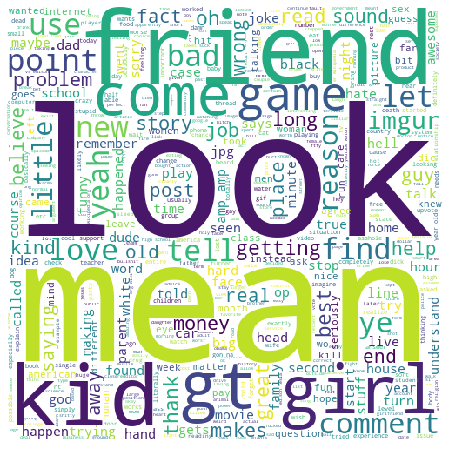

In [93]:
pos_wc = wordcloud.WordCloud(background_color="white", max_words=500, width=1000, height=1000, mode='RGBA', scale=0.5).generate(' '.join(pos_train['clean_sents'].sum()))
plt.figure(figsize=(16,8))
plt.imshow(pos_wc)
plt.axis("off")

(-0.5, 499.5, 499.5, -0.5)

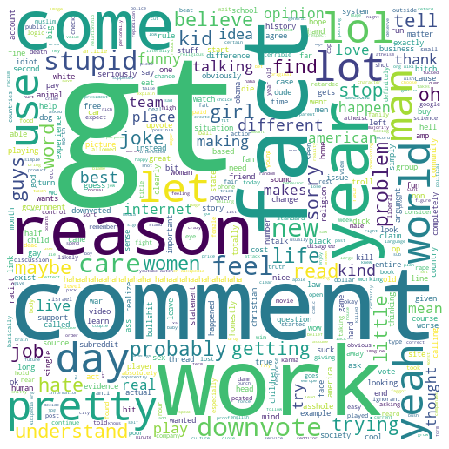

In [95]:
neg_wc = wordcloud.WordCloud(background_color="white", max_words=500, width=1000, height=1000, mode='RGBA', scale=0.5).generate(' '.join(neg_train['clean_sents'].sum()))
plt.figure(figsize=(16,8))
plt.imshow(neg_wc)
plt.axis("off")

From the word clouds, we see that some top terms in highly upvoted comments are: friend, look, mean, kid, girl... and some top terms in highly downvoted comments are: reason, fact, comment, word, year, come... This is really interesting, but we cannot infer important information about our comments solely based on words. We need to do more analysis beyond single words.

## Flat clustering with K-means

The $k$-means approach begins with random clusters of predefined number, then iterates cluster reassignment and evaluates the new clusters relative to an objective function, recursively. To do this we will first select an optimal cluster number using the Silhouette method.

In [17]:
# convert clean_sents to clean_text
pos_train['clean_text'] = pos_train['clean_sents'].apply(' '.join)
neg_train['clean_text'] = neg_train['clean_sents'].apply(' '.join)

/Users/reneehu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/reneehu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [18]:
# convert documents into word count vectorizer
CountVectorizer = sklearn.feature_extraction.text.CountVectorizer()
posVects = CountVectorizer.fit_transform(pos_train['clean_text'])
negVects = CountVectorizer.fit_transform(neg_train['clean_text'])

In [19]:
# tf-idf
TFTransformer = sklearn.feature_extraction.text.TfidfTransformer().fit(posVects)
posTF = TFTransformer.transform(posVects)

TFTransformer = sklearn.feature_extraction.text.TfidfTransformer().fit(negVects)
negTF = TFTransformer.transform(negVects)

In [20]:
# prune matrix of features
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
posTFVects = TFVectorizer.fit_transform(pos_train['clean_text'])
negTFVects = TFVectorizer.fit_transform(neg_train['clean_text'])


In [22]:
PCA = sklearn.decomposition.PCA
pca = PCA(n_components = 2).fit(posTFVects.toarray())
reduced_data = pca.transform(posTFVects.toarray())

### Selecting Cluster Number
A helper function to find the "best" number of clusters...

In [21]:
def plotSilhouette(n_clusters, X):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15,5))
    
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    clusterer = sklearn.cluster.KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    
    silhouette_avg = sklearn.metrics.silhouette_score(X, cluster_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = sklearn.metrics.silhouette_samples(X, cluster_labels)

    y_lower = 10
    
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = matplotlib.cm.get_cmap("nipy_spectral")
        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10
    
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    cmap = matplotlib.cm.get_cmap("nipy_spectral")
    colors = cmap(float(i) / n_clusters)
    ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    projected_centers = pca.transform(centers)
    # Draw white circles at cluster centers
    ax2.scatter(projected_centers[:, 0], projected_centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(projected_centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("PC 1")
    ax2.set_ylabel("PC 2")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()
    print("For n_clusters = {}, The average silhouette_score is : {:.3f}".format(n_clusters, silhouette_avg))

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


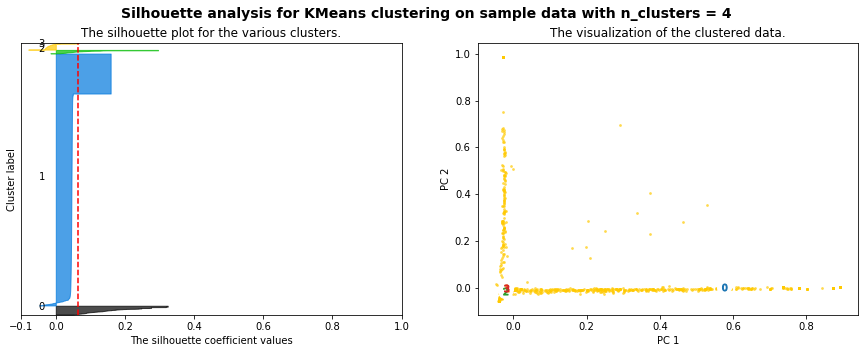

For n_clusters = 4, The average silhouette_score is : 0.064


In [27]:
X = posTFVects.toarray()
plotSilhouette(4, X)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


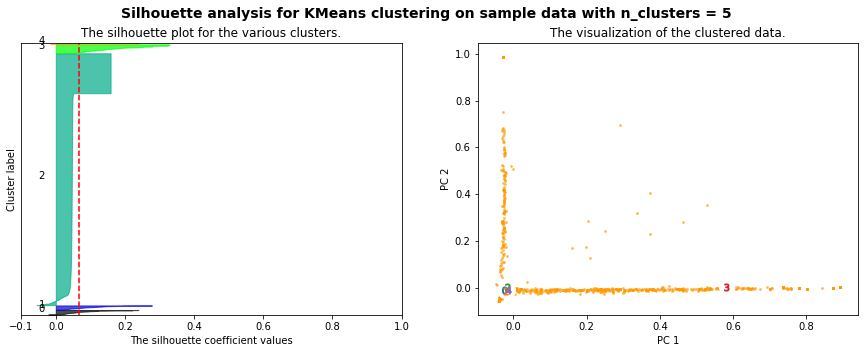

For n_clusters = 5, The average silhouette_score is : 0.066


In [28]:
X = posTFVects.toarray()
plotSilhouette(5, X)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


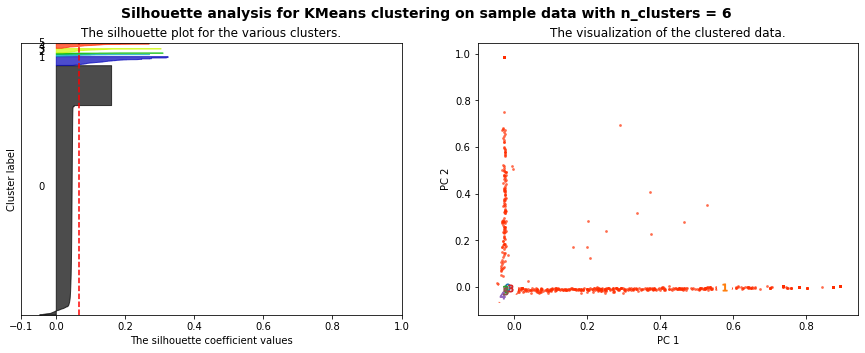

For n_clusters = 6, The average silhouette_score is : 0.067


In [29]:
X = posTFVects.toarray()
plotSilhouette(6, X)

Although the silhouette score of 5 clusters is higher than that of 4 clusters, the increase in average silhouette score after 4 clusters becomes pretty flat, suggesting that the optimal number of cluster is still 4.

### K-means clustering

In [31]:
numClusters = 4

In [32]:
km = sklearn.cluster.KMeans(n_clusters=numClusters, init='k-means++')

In [42]:
km.fit(posTFVects)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [43]:
pos_train['kmeans_predictions'] = km.labels_

In [44]:
pos_terms = TFVectorizer.get_feature_names()
print("Top terms per cluster (positive):")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(numClusters):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % pos_terms[ind])
    print('\n')

Top terms per cluster (positive):
Cluster 0:
 happen
 yea
 gender
 lt
 difference
 means
 officer
 science
 hold
 bought


Cluster 1:
 companies
 ignorant
 innocent
 keeping
 www
 gold
 pointing
 youtube
 reasonable
 watched


Cluster 2:
 random
 completely
 posting
 computer
 rules
 average
 totally
 save
 points
 germany


Cluster 3:
 years
 officer
 lots
 longer
 means
 average
 ground
 liberals
 gif
 videos




In [39]:
km.fit(negTFVects)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [40]:
neg_train['kmeans_predictions'] = km.labels_

In [41]:
neg_terms = TFVectorizer.get_feature_names()
print("Top terms per cluster (negative):")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(numClusters):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % neg_terms[ind])
    print('\n')

Top terms per cluster (negative):
Cluster 0:
 http
 com
 www
 imgur
 jpg
 reddit
 youtube
 watch
 org
 comments


Cluster 1:
 yeah
 comment
 pretty
 oh
 stupid
 read
 man
 sorry
 maybe
 probably


Cluster 2:
 lol
 wtf
 funny
 yeah
 new
 downvote
 true
 dumb
 ok
 asshole


Cluster 3:
 gt
 ftfy
 stop
 use
 means
 needs
 lot
 english
 word
 care




There is a visible difference between top terms generated from highly upvoted comments and those from highly downvoted comments. In highly upvoted comments, the words are more complex and tend to be centered around importance political and social issues. While in highly downvoted comments, many words are simple and colloquial expression. There are also more dirty and sarcastic words.

## Predicting Comment Score
We start with our first problem: Can we predict what type of comments will receive higher attention on social media? That is, are we able to distinguish highly upvoted comments and highly downvoted comments? We start by generating labels based on quartile division of comment scores. Here, scores under 25th percentile represent highly downvoted comments, and scores above 75th percentile represent highly upvoted comments. Then, we construct our features along three dimensions: sentiment, content, and similarity. A more detailed explanation of the methods employed by each dimension will be presented below.

In [325]:
# label each comment based on their scores (votes)
def category(x):
    if x < -10:
        return 0
    if -10 <= x < 0:
        return 1
    if 0 <= x < 116:
        return 2
    else:
        return 3

train['category'] = train['score'].apply(category)

### Sentiment
We use two tools to calculate the sentiment of comments. First, we apply Vader-Sentiment to compute 4 scores: positive, negative, neutral, and compound. Next, we calculate LIWC emotion/cognition features based on word counts.

In [212]:
# Vader-Sentiment
sia = SentimentIntensityAnalyzer()
def sentiment_score(x, y):
    return sia.polarity_scores(x)[y]

train['pos'] = train['text'].apply(sentiment_score, args=['pos'])
train['neu'] = train['text'].apply(sentiment_score, args=['neu'])
train['neg'] = train['text'].apply(sentiment_score, args=['neg'])
train['compound'] = train['text'].apply(sentiment_score, args=['compound'])

In [139]:
def readDict(dictionaryPath):
    catList = collections.OrderedDict()
    catLocation = []
    wordList = {}
    finalDict = collections.OrderedDict()

    # Check to make sure the dictionary is properly formatted
    with open(dictionaryPath, "r") as dictionaryFile:
        for idx, item in enumerate(dictionaryFile):
            if "%" in item:
                catLocation.append(idx)
        if len(catLocation) > 2:
            # If there are apparently more than two category sections, throw error and die
            sys.exit("Invalid dictionary format. Check the number/locations of the category delimiters (%).")

    # Read dictionary as lines
    with open(dictionaryPath, "r") as dictionaryFile:
        lines = dictionaryFile.readlines()

    # Within the category section of the dictionary file, grab the numbers associated with each category
    for line in lines[catLocation[0] + 1:catLocation[1]]:
        catList[re.split(r'\t+', line)[0]] = [re.split(r'\t+', line.rstrip())[1]]

    # Now move on to the words
    for idx, line in enumerate(lines[catLocation[1] + 1:]):
        # Get each line (row), and split it by tabs (\t)
        workingRow = re.split('\t', line.rstrip())
        wordList[workingRow[0]] = list(workingRow[1:])

    # Merge the category list and the word list
    for key, values in wordList.items():
        if not key in finalDict:
            finalDict[key] = []
        for catnum in values:
            workingValue = catList[catnum][0]
            finalDict[key].append(workingValue)
    return (finalDict, catList.values())

def wordCount(data, dictOutput):
    finalDict, catList = dictOutput
    
    # Create a new dictionary for the output
    outList = collections.OrderedDict()

    # Number of non-dictionary words
    nonDict = 0

    # Convert to lowercase
    data = data.lower()

    # Tokenize and create a frequency distribution
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(data)

    fdist = nltk.FreqDist(tokens)
    wc = len(tokens)

    # Using the Porter stemmer for wildcards, create a stemmed version of the data
    porter = nltk.PorterStemmer()
    stems = [porter.stem(word) for word in tokens]
    fdist_stem = nltk.FreqDist(stems)

    # Access categories and populate the output dictionary with keys
    for cat in catList:
        outList[cat[0]] = 0

    # Dictionaries are more useful
    fdist_dict = dict(fdist)
    fdist_stem_dict = dict(fdist_stem)

    # Number of classified words
    classified = 0

    for key in finalDict:
        if "*" in key and key[:-1] in fdist_stem_dict:
            classified = classified + fdist_stem_dict[key[:-1]]
            for cat in finalDict[key]:
                outList[cat] = outList[cat] + fdist_stem_dict[key[:-1]]
        elif key in fdist_dict:
            classified = classified + fdist_dict[key]
            for cat in finalDict[key]:
                outList[cat] = outList[cat] + fdist_dict[key]

    # Calculate the percentage of words classified
    if wc > 0:
        percClassified = (float(classified) / float(wc)) * 100
    else:
        percClassified = 0

    # Return the categories, the words used, the word count, the number of words classified, and the percentage of words classified.
    return [outList, tokens, wc, classified, percClassified]

Compute LIWC emotion/cognition features based on word counts...

In [148]:
liwc_dict = readDict('LIWC2007_English100131.dic')

def liwc(text, liwc_dict, keyword):
    # Using LIWC 2007 with different categories
    liwc_counts = wordCount(text, liwc_dict)
    
    if liwc_counts[2]:
        return liwc_counts[0][keyword]/liwc_counts[2]
    else:
        return 0

In [157]:
train['sexual'] = train['text'].apply(liwc, args=(liwc_dict, 'sexual'))
train['insight'] = train['text'].apply(liwc, args=(liwc_dict, 'insight'))
train['cause'] = train['text'].apply(liwc, args=(liwc_dict, 'cause'))
train['discrep'] = train['text'].apply(liwc, args=(liwc_dict, 'discrep'))
train['tentat'] = train['text'].apply(liwc, args=(liwc_dict, 'tentat'))
train['certain'] = train['text'].apply(liwc, args=(liwc_dict, 'certain'))
train['inhib'] = train['text'].apply(liwc, args=(liwc_dict, 'inhib'))

### Content
We evaluate the content structure of comments using two methods: LIWC syntax words and Readability Index.

In [ ]:
train['verb'] = train['text'].apply(liwc, args=(liwc_dict, 'verb'))
train['ppron'] = train['text'].apply(liwc, args=(liwc_dict, 'ppron'))

In [161]:
train['fk_grade'] = train['text'].apply(textstat.flesch_kincaid_grade)
train['fog_index'] = train['text'].apply(textstat.gunning_fog)

### Similarity
To evaluate comment-parent comment similarity, we first vectorize each word using word2vec and compute centroids weighted by sum of all word vectors in the comment. The we calculate the cosine similarity between comment vector and parent comment vector. We also include parent features in our model, including parent score and their controversiality.

In [188]:
train['tokenized_parents'] = train['parent_text'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])
train['normalized_parents'] = train['tokenized_parents'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s, lemma=False) for s in x])


In [170]:
W2V = gensim.models.word2vec.Word2Vec(train['normalized_sents'].sum(), min_count=1)

In [189]:
parentW2V = gensim.models.word2vec.Word2Vec(train['normalized_parents'].sum(), min_count=1)

In [169]:
# vectorize each comment based on the weighted sum of all the word vectors in a comment
def word_freq(tokens):
    d = defaultdict(int)
    def count(tokens):
        for i in tokens:
            if isinstance(i, list):
                count(i)
            else:
                d[i] += 1
        return d
    return count(tokens)

def doc2vec(tokens, parent):
    d = word_freq(tokens)
    s = w = 0
    for i in d:
        s += (W2V, parentW2V)[parent][i] * (1 / math.log(1 + d[i]))
        w += 1 / math.log(1 + d[i])
    if w:
        return s / w
    else:
        return None

In [173]:
weighted_vect = []
for _, i in train['normalized_sents'].iteritems():
    weighted_vect.append(doc2vec(i, 0))
train['weighted_vect'] = weighted_vect

In [190]:
weighted_par_vect = []
for _, i in train['normalized_parents'].iteritems():
    try:
        weighted_par_vect.append(doc2vec(i, 1))
    except KeyError:
        weighted_par_vect.append(None)
train['weighted_par_vect'] = weighted_par_vect

In [208]:
def similarity(x, y):
    if x is not None and y is not None:
        return sklearn.metrics.pairwise.cosine_similarity(x.reshape(1, -1), y.reshape(1, -1))
    else:
        return 0
train['similarity'] = train.apply(lambda x: similarity(x.weighted_vect, x.weighted_par_vect), axis=1)

def rp(x):
    if x == 0:
        return x
    else:
        return x[0][0]
train['similarity'] = train['similarity'].apply(rp)

### Fitting our Models
We train three classifers with careful hyperparameter tuning and cross-validation: Logistic Regression, KNN, and Random Forest.

In [45]:
features = ['pos', 'neu', 'neg', 'compound', 'sexual', 'insight', 'cause', 'discrep',
            'tentat', 'inhib', 'certain', 'verb', 'ppron', 'fk_grade', 'fog_index', 'similarity', 
            'controversiality', 'parent_controversiality', 'parent_score']

In [321]:
parameters = {'C':np.concatenate((np.arange(0, 1, 0.1), np.arange(1, 20)))}
logistic = LogisticRegression()
clf = GridSearchCV(logistic, parameters, cv=5)
best_logistic = clf.fit(train[features], train['category'])
best_logistic

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,
        2. ,  3. ,  4. ,  5. ,  6. ,  7. ,  8. ,  9. , 10. , 11. , 12. ,
       13. , 14. , 15. , 16. , 17. , 18. , 19. ])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [322]:
best_logistic.score(train[features], train['category'])

0.4602

In [287]:
parameters = {'weights':('uniform', 'distance'), 'n_neighbors': list(range(5, 20))}
knn = KNeighborsClassifier()
clf = GridSearchCV(knn, parameters, cv=5)
best_knn = clf.fit(train[features], train['category'])
best_knn

GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'algorithm': ('auto', 'ball_tree', 'kd_tree', 'brute'),
                         'n_neighbors': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,
                                         16, 17, 18, 19],
                         'weights': ('uniform', 'distance')},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [288]:
best_knn.score(train[features], train['category'])

0.55645

In [293]:
# Instantiate model with 100 decision trees
rf = RandomForestClassifier(n_estimators = 100, random_state = 1234)
# Train the model on training data
rf.fit(train[features], train['category'])
rf.score(train[features], train['category'])

0.9999

### Prediction on Test Set
We first compute all the features in the test set, and then evaluate the performance of our models using various metrics: accuracy rate over all comments and in each class, F1 score, AUC (one vs. rest), and Cohen's Kappa.

In [242]:
test['tokenized_sents'] = test['text'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])
test['normalized_sents'] = test['tokenized_sents'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s, lemma=False) for s in x])


In [ ]:
test['tokenized_parents'] = test['parent_text'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])
test['normalized_parents'] = test['tokenized_parents'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s, lemma=False) for s in x])


In [243]:
test['category'] = test['score'].apply(category)

test['pos'] = test['text'].apply(sentiment_score, args=['pos'])
test['neu'] = test['text'].apply(sentiment_score, args=['neu'])
test['neg'] = test['text'].apply(sentiment_score, args=['neg'])
test['compound'] = test['text'].apply(sentiment_score, args=['compound'])
test['sexual'] = test['text'].apply(liwc, args=(liwc_dict, 'sexual'))
test['insight'] = test['text'].apply(liwc, args=(liwc_dict, 'insight'))
test['cause'] = test['text'].apply(liwc, args=(liwc_dict, 'cause'))
test['discrep'] = test['text'].apply(liwc, args=(liwc_dict, 'discrep'))
test['tentat'] = test['text'].apply(liwc, args=(liwc_dict, 'tentat'))
test['certain'] = test['text'].apply(liwc, args=(liwc_dict, 'certain'))
test['inhib'] = test['text'].apply(liwc, args=(liwc_dict, 'inhib'))

test['verb'] = test['text'].apply(liwc, args=(liwc_dict, 'verb'))
test['ppron'] = test['text'].apply(liwc, args=(liwc_dict, 'ppron'))
test['fk_grade'] = test['text'].apply(textstat.flesch_kincaid_grade)
test['fog_index'] = test['text'].apply(textstat.gunning_fog)

In [273]:
W2V = gensim.models.word2vec.Word2Vec(test['normalized_sents'].sum(), min_count=1)

In [275]:
parentW2V = gensim.models.word2vec.Word2Vec(test['normalized_parents'].sum(), min_count=1)

In [276]:
weighted_vect = []
for _, i in test['normalized_sents'].iteritems():
    weighted_vect.append(doc2vec(i, 0))
test['weighted_vect'] = weighted_vect

In [277]:
weighted_par_vect = []
for _, i in test['normalized_parents'].iteritems():
    try:
        weighted_par_vect.append(doc2vec(i, 1))
    except KeyError:
        weighted_par_vect.append(None)
test['weighted_par_vect'] = weighted_par_vect

In [278]:
test['similarity'] = test.apply(lambda x: similarity(x.weighted_vect, x.weighted_par_vect), axis=1)
test['similarity'] = test['similarity'].apply(rp)

Test Accuracy:

In [557]:
test['majority'] = [1] * len(test.index)
print('Test accuracy of baseline model is {}'.format(accuracy_score(test['majority'], test['category'])))

Test accuracy of baseline model is 0.2594


In [342]:
test['logistic'] = best_logistic.predict(test[features])
print('Test accuracy of logistic regression is {}'.format(accuracy_score(test['logistic'], test['category'])))

Test accuracy of logistic regression is 0.4519


In [340]:
test['knn'] = best_knn.predict(test[features])
print('Test accuracy of KNN is {}'.format(accuracy_score(test['knn'], test['category'])))

Test accuracy of KNN is 0.49


In [341]:
test['rf'] = rf.predict(test[features])
print('Test accuracy of random forest is {}'.format(accuracy_score(test['rf'], test['category'])))

Test accuracy of random forest is 0.4951


In [339]:
test_c0 = test[test['category'] == 0]
print('Accuracy of logistic regression for category 0:', accuracy_score(test_c0['logistic'], test_c0['category']))
test_c1 = test[test['category'] == 1]
print('Accuracy of logistic regression for category 1:', accuracy_score(test_c1['logistic'], test_c1['category']))
test_c2 = test[test['category'] == 2]
print('Accuracy of logistic regression for category 2:', accuracy_score(test_c2['logistic'], test_c2['category']))
test_c3 = test[test['category'] == 3]
print('Accuracy of logistic regression for category 3:', accuracy_score(test_c3['logistic'], test_c3['category']))

Accuracy of logistic regression for category 0: 0.22236076475477973
Accuracy of logistic regression for category 1: 0.7193523515805705
Accuracy of logistic regression for category 2: 0.21659353809333864
Accuracy of logistic regression for category 3: 0.631768953068592


In [335]:
test_c0 = test[test['category'] == 0]
print('Accuracy of KNN for category 0:', accuracy_score(test_c0['knn'], test_c0['category']))
test_c1 = test[test['category'] == 1]
print('Accuracy of KNN for category 1:', accuracy_score(test_c1['knn'], test_c1['category']))
test_c2 = test[test['category'] == 2]
print('Accuracy of KNN for category 2:', accuracy_score(test_c2['knn'], test_c2['category']))
test_c3 = test[test['category'] == 3]
print('Accuracy of KNN for category 3:', accuracy_score(test_c3['knn'], test_c3['category']))

Accuracy of KNN for category 0: 0.30673316708229426
Accuracy of KNN for category 1: 0.5609097918272937
Accuracy of KNN for category 2: 0.46868767451136817
Accuracy of KNN for category 3: 0.6145206578419575


In [337]:
test_c0 = test[test['category'] == 0]
print('Accuracy of random forest for category 0:', accuracy_score(test_c0['rf'], test_c0['category']))
test_c1 = test[test['category'] == 1]
print('Accuracy of random forest for category 1:', accuracy_score(test_c1['rf'], test_c1['category']))
test_c2 = test[test['category'] == 2]
print('Accuracy of random forest for category 2:', accuracy_score(test_c2['rf'], test_c2['category']))
test_c3 = test[test['category'] == 3]
print('Accuracy of random forest for category 3:', accuracy_score(test_c3['rf'], test_c3['category']))

Accuracy of random forest for category 0: 0.2589359933499584
Accuracy of random forest for category 1: 0.5944487278334618
Accuracy of random forest for category 2: 0.5061826884722777
Accuracy of random forest for category 3: 0.6085038106698757


F1 score:

In [558]:
print('F1 score')
print('logistic regression:', f1_score(test['logistic'], test['category'], average='weighted'))
print('knn:', f1_score(test['knn'], test['category'], average='weighted'))
print('random forest:', f1_score(test['rf'], test['category'], average='weighted'))
print('baseline model:', f1_score(test['majority'], test['category'], average='weighted'))

F1 score
logistic regression: 0.4763720971219862
knn: 0.49380641656415664
random forest: 0.5036219879993306
baseline model: 0.411942194695887


AUC score:

In [562]:
print('AUC score')
print('logistic regression:', roc_auc_score(test['category'], 
                                            best_logistic.predict_proba(test[features]), multi_class='ovr'))
print('knn:', roc_auc_score(test['category'], best_knn.predict_proba(test[features]), multi_class='ovr'))
print('random forest:', roc_auc_score(test['category'], rf.predict_proba(test[features]), multi_class='ovr'))
print('baseline model:', roc_auc_score(test['category'], [[0, 1, 0, 0] for _ in range(10000)], multi_class='ovr'))

AUC score
logistic regression: 0.7297930091231457
knn: 0.759347564414466
random forest: 0.7652863102501137
baseline model: 0.5


Cohen's Kappa

In [563]:
print('Cohen\'s Kappa')
print('logistic regression:', cohens_kappa(test['logistic'], test['category']))
print('knn:', cohens_kappa(test['knn'], test['category']))
print('random forest:', cohens_kappa(test['rf'], test['category']))
print('baseline model:', cohens_kappa(test['majority'], test['category']))

Cohen's Kappa
logistic regression: 0.267284466665975
knn: 0.31944253269328016
random forest: 0.3257431248233899
baseline model: 0.0


Category-wise, Q2 (slightly downvoted comments) and Q4 (highly upvoted comments) achieve the highest test accuracy. For evaluation on all comments, Random Forest outperforms all the other models on overall accuracy, F1, AUC, and Cohen's Kappa.

## Feature Importance
Our goal is to understand the features that are the best predictors for high scoring and low scoring comments. We calculate the permutation feature importance to find distinguishing features in our models. The function looks at the drop in the model accuracy score when a single feature value is randomly shuffled and is calculated with different permutations of the feature. For convenience, we plot the top 5 important features for each model and for Q2 and Q4 in each model.

In [537]:
test['category_0'] = test['category'] == 0
test['category_1'] = test['category'] == 1
test['category_2'] = test['category'] == 2
test['category_3'] = test['category'] == 3

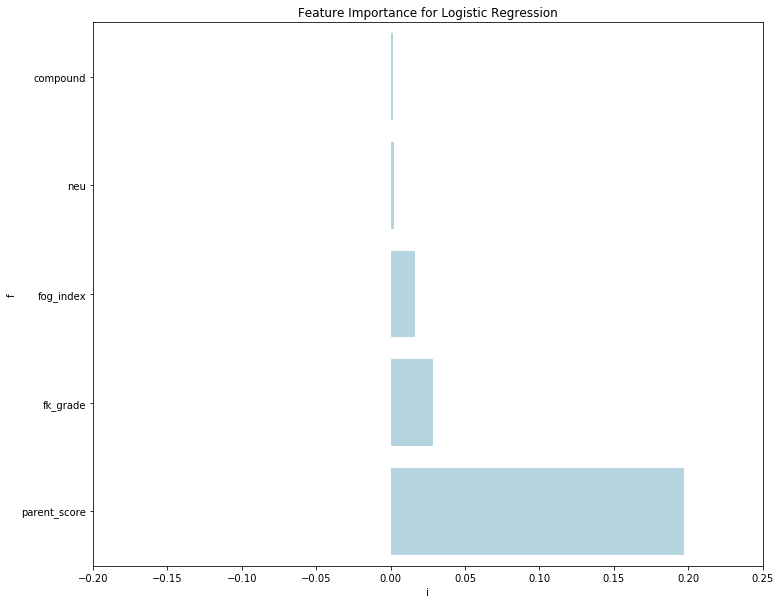

In [523]:
from sklearn.inspection import permutation_importance
features = pd.Series(features)

def plot_pi(ml):
    imp_mean = permutation_importance(ml, test[features], test['category'])['importances_mean']
    top_indices = np.argpartition(np.array([abs(i) for i in imp_mean]), -5)[-5:]
    df_plot = pd.DataFrame({'f': features[top_indices], 'i': imp_mean[top_indices]})
    ax = sns.barplot(y='f', x='i', color='lightblue', data=df_plot)
    ax.set_xlim(-0.2, 0.25)
    
    return ax
        
plt.figure(figsize=(12, 10))
logistic_plot = plot_pi(best_logistic)
plt.title('Feature Importance for Logistic Regression');

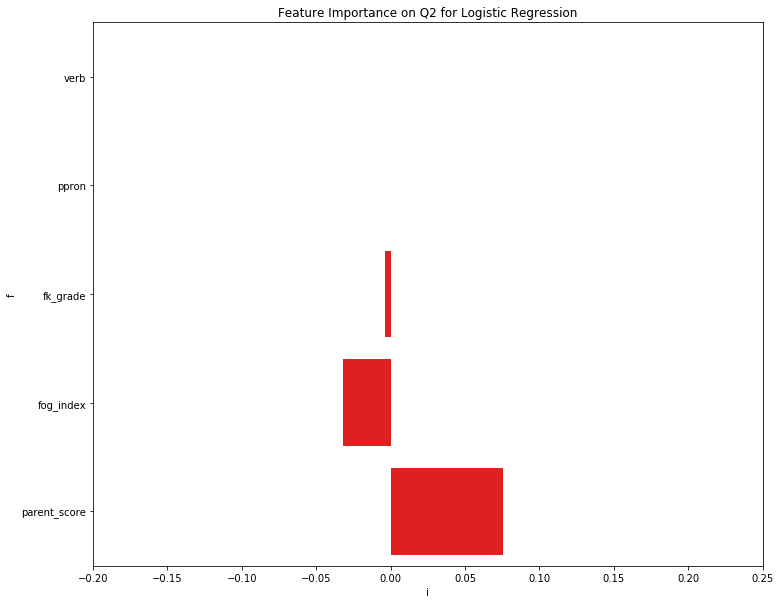

In [551]:
imp_mean = permutation_importance(best_logistic, test[features], test['category_1'])['importances_mean']
top_indices = np.argpartition(np.array([abs(i) for i in imp_mean]), -5)[-5:]
plt.figure(figsize=(12, 10))
df_plot = pd.DataFrame({'f': features[top_indices], 'i': imp_mean[top_indices]})
ax_c0_log = sns.barplot(y='f', x='i', color='red', data=df_plot)
ax_c0_log.set_xlim(-0.2, 0.25)
plt.title('Feature Importance on Q2 for Logistic Regression');

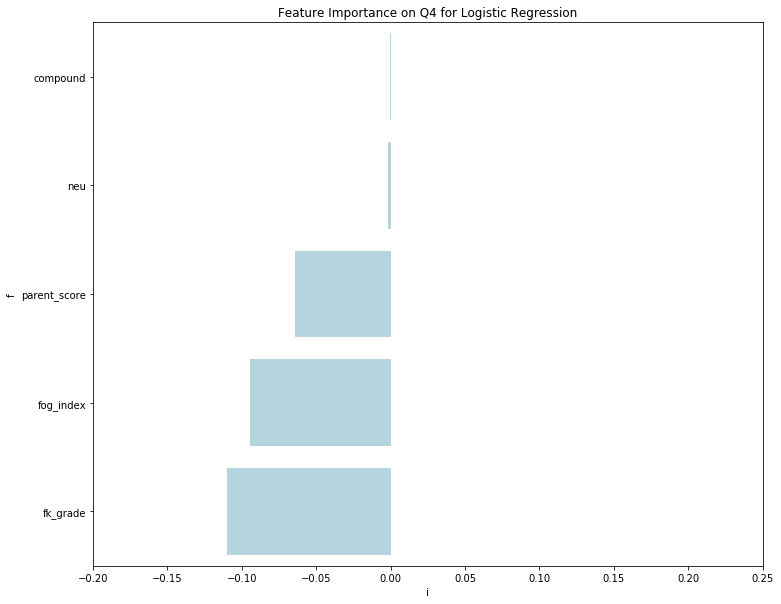

In [547]:
imp_mean = permutation_importance(best_logistic, test[features], test['category_3'])['importances_mean']
top_indices = np.argpartition(np.array([abs(i) for i in imp_mean]), -5)[-5:]
plt.figure(figsize=(12, 10))
df_plot = pd.DataFrame({'f': features[top_indices], 'i': imp_mean[top_indices]})
ax_c3_log = sns.barplot(y='f', x='i', color='lightblue', data=df_plot)
ax_c3_log.set_xlim(-0.2, 0.25)
plt.title('Feature Importance on Q4 for Logistic Regression');

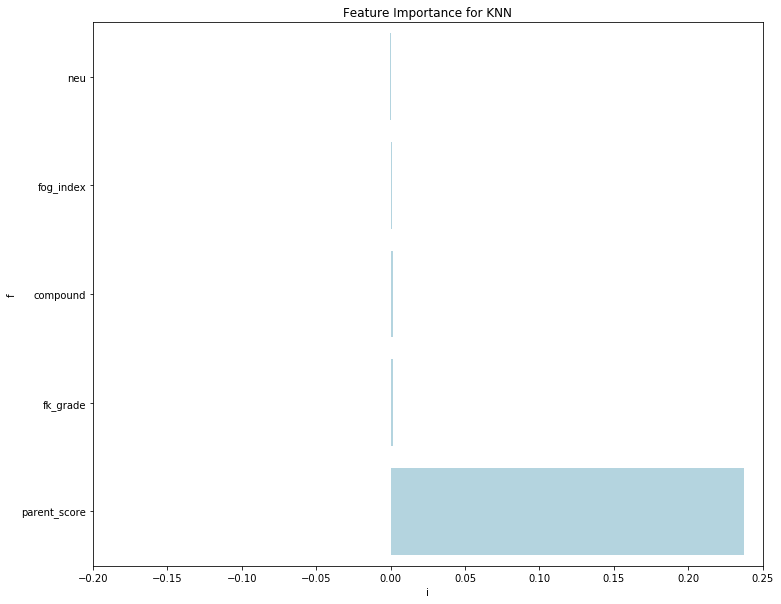

In [527]:
plt.figure(figsize=(12, 10))
knn_plot = plot_pi(best_knn)
plt.title('Feature Importance for KNN');

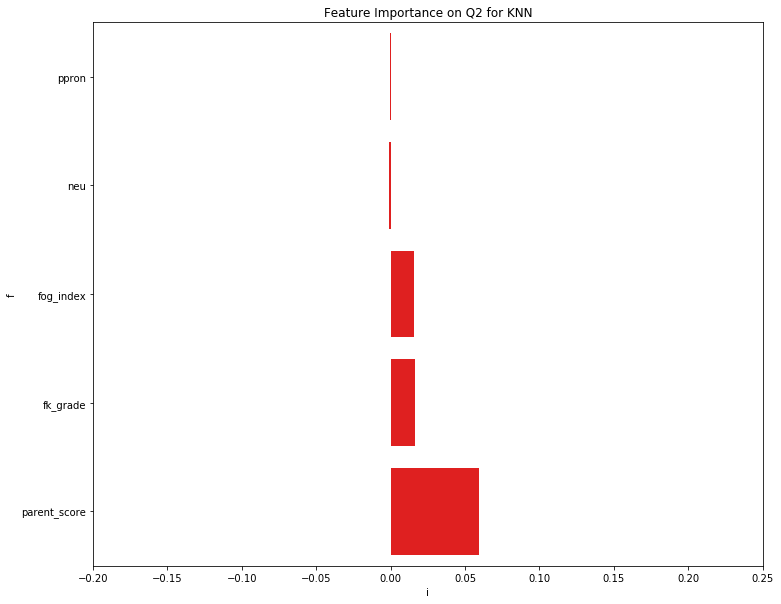

In [552]:
imp_mean = permutation_importance(best_knn, test[features], test['category_1'])['importances_mean']
top_indices = np.argpartition(np.array([abs(i) for i in imp_mean]), -5)[-5:]
plt.figure(figsize=(12, 10))
df_plot = pd.DataFrame({'f': features[top_indices], 'i': imp_mean[top_indices]})
ax_c0_knn = sns.barplot(y='f', x='i', color='red', data=df_plot)
ax_c0_knn.set_xlim(-0.2, 0.25)
plt.title('Feature Importance on Q2 for KNN');

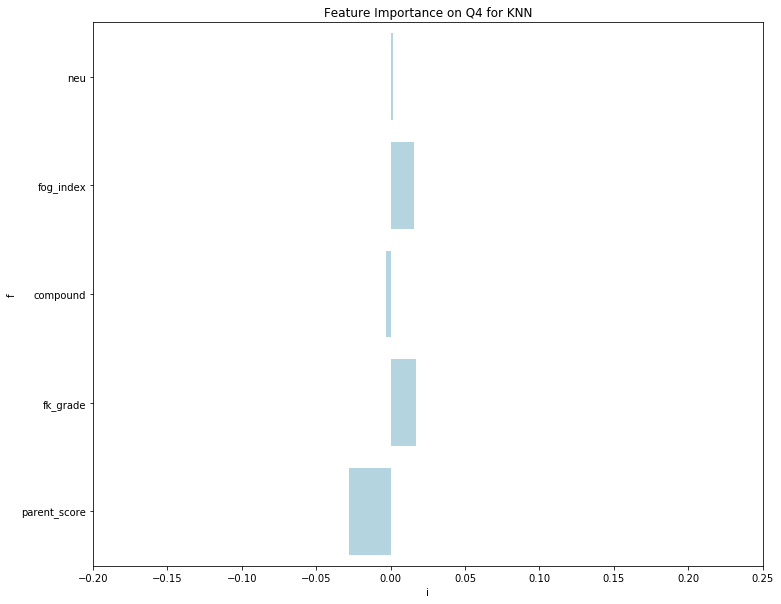

In [543]:
imp_mean = permutation_importance(best_knn, test[features], test['category_3'])['importances_mean']
top_indices = np.argpartition(np.array([abs(i) for i in imp_mean]), -5)[-5:]
plt.figure(figsize=(12, 10))
df_plot = pd.DataFrame({'f': features[top_indices], 'i': imp_mean[top_indices]})
ax_c3_knn = sns.barplot(y='f', x='i', color='lightblue', data=df_plot)
ax_c3_knn.set_xlim(-0.2, 0.25)
plt.title('Feature Importance on Q4 for KNN');

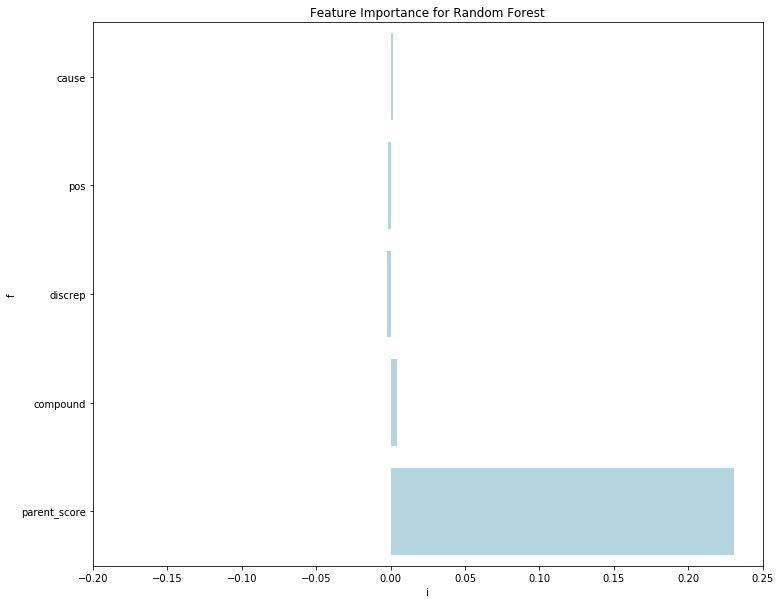

In [526]:
plt.figure(figsize=(12, 10))
rf_plot = plot_pi(rf)
plt.title('Feature Importance for Random Forest');

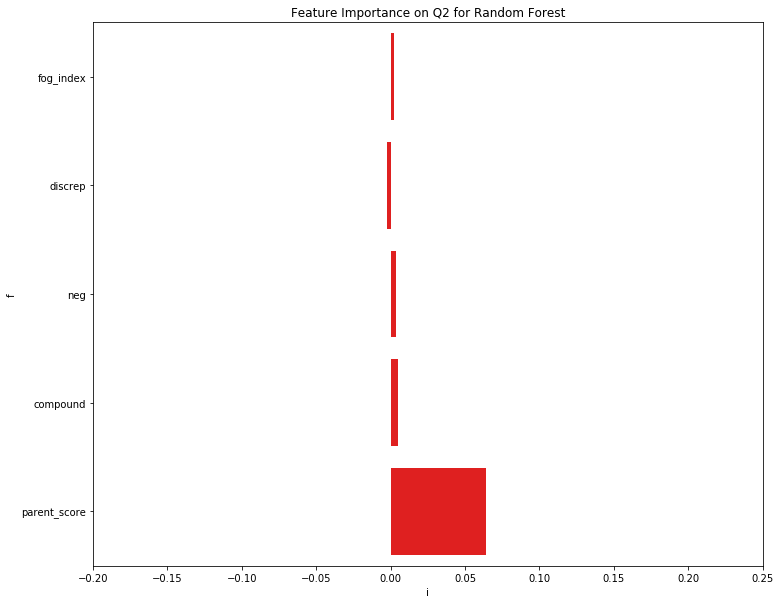

In [553]:
imp_mean = permutation_importance(rf, test[features], test['category_1'])['importances_mean']
top_indices = np.argpartition(np.array([abs(i) for i in imp_mean]), -5)[-5:]
plt.figure(figsize=(12, 10))
df_plot = pd.DataFrame({'f': features[top_indices], 'i': imp_mean[top_indices]})
ax_c0_rf = sns.barplot(y='f', x='i', color='red', data=df_plot)
ax_c0_rf.set_xlim(-0.2, 0.25)
plt.title('Feature Importance on Q2 for Random Forest');

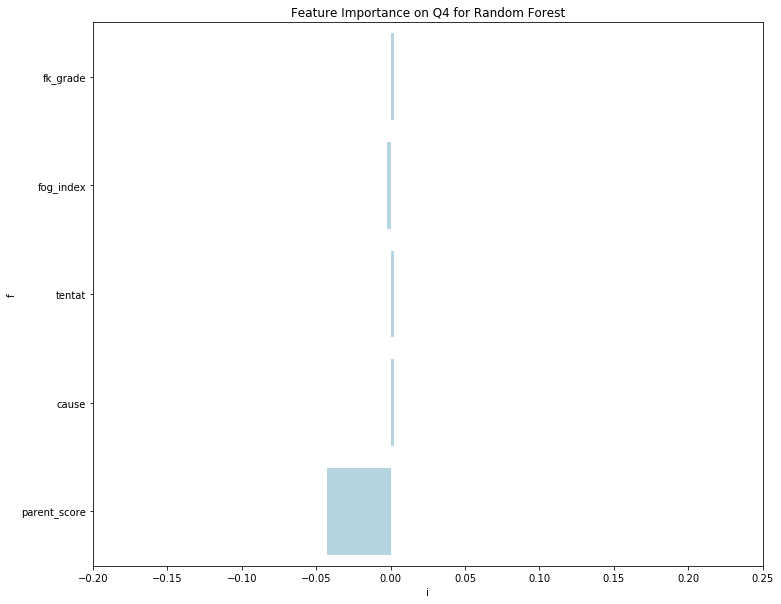

In [545]:
imp_mean = permutation_importance(rf, test[features], test['category_3'])['importances_mean']
top_indices = np.argpartition(np.array([abs(i) for i in imp_mean]), -5)[-5:]
plt.figure(figsize=(12, 10))
df_plot = pd.DataFrame({'f': features[top_indices], 'i': imp_mean[top_indices]})
ax_c3_rf = sns.barplot(y='f', x='i', color='lightblue', data=df_plot)
ax_c3_rf.set_xlim(-0.2, 0.25)
plt.title('Feature Importance on Q4 for Random Forest');

From these plots, we conclude that parent score and readability are the two most important features in categorizing Q2 (slightly downvoted comments) and Q4 (highly upvoted comments). What distinguishes our prediction for Q2 and Q4  is the direction of feature importance on parent score. In Q2, the importance is positive and in Q4, the importance is negative. Also, readability is an important measure in Logistic Regression and KNN. Its value and direction, though, vary among the models.

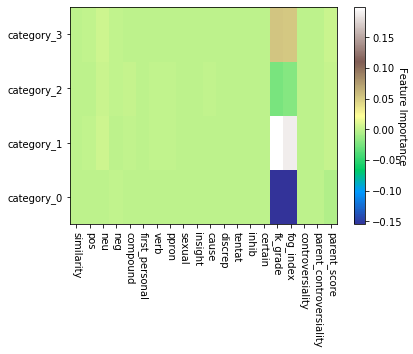

In [384]:
imp_mean_c0 = permutation_importance(best_logistic, test_c0[features], test_c0['category'])['importances_mean']
imp_mean_c1 = permutation_importance(best_logistic, test_c1[features], test_c1['category'])['importances_mean']
imp_mean_c2 = permutation_importance(best_logistic, test_c2[features], test_c2['category'])['importances_mean']
imp_mean_c3 = permutation_importance(best_logistic, test_c3[features], test_c3['category'])['importances_mean']
heatmapMatrix = np.array([imp_mean_c0, imp_mean_c1, imp_mean_c2, imp_mean_c3])

categories = ['category_' + str(i) for i in range(4)]

fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrix, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('Feature Importance', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrix.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrix.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(features, minor=False, rotation=270)
a = ax.set_yticklabels(categories, minor=False)

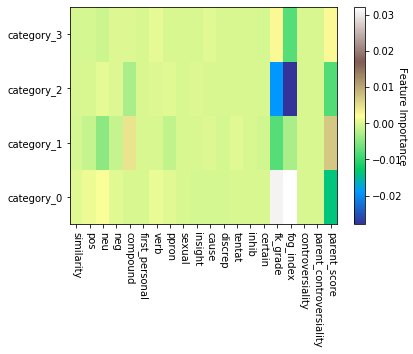

In [385]:
imp_mean_c0 = permutation_importance(best_knn, test_c0[features], test_c0['category'])['importances_mean']
imp_mean_c1 = permutation_importance(best_knn, test_c1[features], test_c1['category'])['importances_mean']
imp_mean_c2 = permutation_importance(best_knn, test_c2[features], test_c2['category'])['importances_mean']
imp_mean_c3 = permutation_importance(best_knn, test_c3[features], test_c3['category'])['importances_mean']
heatmapMatrix = np.array([imp_mean_c0, imp_mean_c1, imp_mean_c2, imp_mean_c3])

categories = ['category_' + str(i) for i in range(4)]

fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrix, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('Feature Importance', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrix.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrix.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(features, minor=False, rotation=270)
a = ax.set_yticklabels(categories, minor=False)

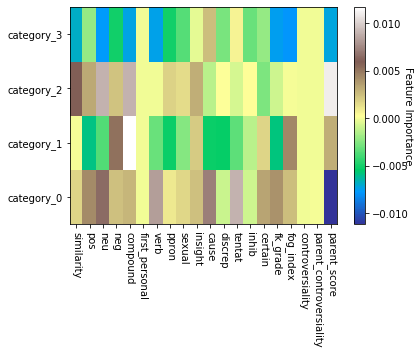

In [386]:
imp_mean_c0 = permutation_importance(rf, test_c0[features], test_c0['category'])['importances_mean']
imp_mean_c1 = permutation_importance(rf, test_c1[features], test_c1['category'])['importances_mean']
imp_mean_c2 = permutation_importance(rf, test_c2[features], test_c2['category'])['importances_mean']
imp_mean_c3 = permutation_importance(rf, test_c3[features], test_c3['category'])['importances_mean']
heatmapMatrix = np.array([imp_mean_c0, imp_mean_c1, imp_mean_c2, imp_mean_c3])

categories = ['category_' + str(i) for i in range(4)]

fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrix, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('Feature Importance', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrix.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrix.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(features, minor=False, rotation=270)
a = ax.set_yticklabels(categories, minor=False)